# Data Interpolation in Latent Space

In this notebook, we'll demonstrate our results and experiments for data interpolation in latent space. In the first part we'll show demonstrate data interpolation, assuming selected DAE that were trained, and generated encodings. at the end of this notebook, you can find our DAE pytorch model class, along with anything needed to run a grid search and training. recommeded to first Part 1, and only then Part 2.



# Part 1- Data interpolation

In [ ]:
from pathlib import Path
import torch
import json
import numpy as np
from scipy.spatial import distance
from models.DAE import Decoder
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import PIL.Image as Image
import random

In [31]:
###IO utils ###

def get_device():
    return torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def to_img(img):
    img = 0.5 * (img + 1)
    img = img.clamp(0, 1)
    img = img.view(img.size(0), 3, 64, 64)
    return img

def unpack_archive(path):
    shutil.unpack_archive(path)


In [2]:
###Model loading ###

def load_config(base_path, config_path=None):
    if config_path is None:
        config_path = Path(base_path) / Path('config.json')
    with config_path.open() as f:
        config = json.load(f)
    return config

def load_model(base_path, model_path=None):
    if model_path is None:
        model_path = Path(base_path) / Path('model.pth')
    config = load_config(base_path)
    dims= config['dims']
    device = get_device()
    state_dict = torch.load(model_path, map_location=torch.device(device))
    decoder = Decoder(dims)
    decoder.load_state_dict(state_dict['decoder'])
    decoder.to(device)
    return decoder

def load_encoding(base_path, encoding_path=None):
    if encoding_path is None:
        encoding_path = Path(base_path) / Path('encoding.json')
    with encoding_path.open() as f:
        points_data = json.load(f)
    for p in points_data:
        p['img'] = np.asarray(Image.open(p['path']))
    return points_data


In [3]:
###Model evaluation ###

def describe(config, model, encoding):
    print("*"*80)
    print("model is:")
    print(model)
    print("*"*80)

    print("*"*80)
    print("model was trained with:")
    print(json.dumps(config, indent=4, sort_keys=True))
    print("*"*80)
    
    print('comparing original images (not noised) to their corresponding autoencoder output. mse is calculated in rgb space')
    print("MSE:{}".format(encoding_mse(encoding, model)))
    print("*"*80)
    
    points=[p['z'] for p in encoding]
    print("first image can be found at found at {}".format(encoding[0]['path']))
    print('there are {} points encoded'.format(pd.DataFrame(points).shape[0]))
    print('each point has {} dimensions'.format(len(points[0])))
    print('first 5 points are:')
    print(pd.DataFrame(points).head())
    print("*****************")
    

def latent_to_img(vector, decoder):
    device = get_device()
    reshaped = torch.from_numpy(np.expand_dims(np.array(vector), axis=0)).type(torch.FloatTensor).to(device)
    original = decoder(reshaped)
    img = to_img(original)[0].permute(1,2,0).detach().numpy()
    return img

def encoding_mse(encoding, model, sample_size=100):
    ### comparing original images (not noised) to their corresponding autoencoder output. mse is calculated in rgb space###
    ### sampling is done for performace ###
    sampled_encoding = random.sample(encoding, sample_size)
    points = [p['z'] for p in sampled_encoding]
    true_imgs = [p['img'] for p in sampled_encoding]
    total = 0.0
    for point, true_img in zip(points, true_imgs):
        pred_img = Image.fromarray((latent_to_img(point, model) *255).astype(np.uint8), 'RGB')
        diff = true_img - pred_img
        total+=(diff**2).mean()
    return total / len(points)

def show_true_vs_decoded(encoding,model, idx):
    p = encoding[0]['z']
    true_img= encoding[0]['img']
    pred_img = Image.fromarray((latent_to_img(p, model) *255).astype(np.uint8), 'RGB')

    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(true_img)
    ax1.set_title('original')
    ax1.axis('off')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(pred_img)
    ax2.set_title('decoded')
    ax2.axis('off');
    plt.show()


In [4]:
### Graph utils ###

def add_edges(G, knn_graph, distances, k):
    n = G.number_of_nodes()
    deg = G.degree[0]
    for u in range(n):
        for v in range(deg, k):
            neighbor = knn_graph[u][v]
            G.add_edge(u, neighbor, weight=distances[u][neighbor])
    return G


def add_nodes(G, points):
    for u in np.arange(len(points)):
        G.add_node(u, pos=tuple(points[u]))

def get_sorted_nn_graph(distances):
    knn_graph = np.argsort(distances, axis=1, kind='stable')[:, 1:]  # node is closest to itself always
    return knn_graph


def get_graph(points, dist_type='euclidean', k=None, start_k=2, max_k=100):
    distances = distance.cdist(points, points, dist_type)
    knn_graph = get_sorted_nn_graph(distances)
    G = nx.Graph()
    add_nodes(G, points)
    if k is None:
        for i in range(start_k, max_k):
            add_edges(G, knn_graph, distances, i)
            if nx.is_connected(G):
                return G
    else:
        add_edges(G, knn_graph, distances, k)
        return G
    return None # couldnt find connection


def get_most_distant_points(points, dist_type='euclidean'):
    distances = distance.cdist(points, points, dist_type)
    I = np.unravel_index(distances.argmax(), distances.shape)
    return I


def get_shortest_path_graph(G, source, destination):
    path = nx.dijkstra_path(G, source, destination, weight='weight')
    G2= nx.Graph()
    G2.add_nodes_from(G.nodes(data=True))
    for i in range(len(path)-1):
        data = G.get_edge_data(path[i], path[i+1])
        G2.add_edge(path[i], path[i+1], weight=data['weight'])
    return G2, path

def display_path_graph(G, path):
    G2= nx.Graph()
    G2.add_nodes_from(G.nodes(data=True))
    for i in range(len(path)-1):
        G2.add_edge(path[i], path[i+1])
    display_latent_space(G2, with_edges=True)

def display_latent_space(G, with_edges=False, view_params=None):
    if view_params is None:
        view_params = (50, 70)
    pos= nx.get_node_attributes(G,'pos')
    if len(points[0])==2:
        if not with_edges:
            nx.draw_networkx_nodes(G, pos, node_size=5)
        else:
            nx.draw(G, pos, node_size=5)
        plt.show()
    if len(points[0])==3:
        %matplotlib inline 
        pos = nx.get_node_attributes(G, 'pos')
        angle = 0
        with plt.style.context(('ggplot')):

            fig = plt.figure(figsize=(10,7))
            ax = Axes3D(fig)

            # Loop on the pos dictionary to extract the x,y,z coordinates of each node

            for key, value in pos.items():
                xi = value[0]
                yi = value[1]
                zi = value[2]
                #rint('here')
                ax.scatter(xi, yi, zi, s=1, c='blue')
            
            if with_edges:
                for i,j in enumerate(G2.edges()):
                    x = np.array((pos[j[0]][0], pos[j[1]][0]))
                    y = np.array((pos[j[0]][1], pos[j[1]][1]))
                    z = np.array((pos[j[0]][2], pos[j[1]][2]))
                    ax.plot(x, y, z, c='black', alpha=0.5)
        
        # Set the initial view
        ax.view_init(view_params[0], view_params[1])
        # Hide the axes
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        print('wait a bit for 3d graph to be displayed')
        plt.show()

        
def display_3d_convex_hull():
    if len(points[0])==3:
        from scipy.spatial import ConvexHull
        pts = np.array(points)

        hull = ConvexHull(pts)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        # Plot defining corner points
        #ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

        # 12 = 2 * 6 faces are the simplices (2 simplices per square face)
        for s in hull.simplices:
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

        # Make axis label
        for i in ["x", "y", "z"]:
            eval("ax.set_{:s}label('{:s}')".format(i, i))

        plt.show()
    else:
        raise NotImplemented('not implemented convex hull for 2d')

        
def display_neighbors_for_latent_image(encoding, model, idx):
    points = [p['z'] for p in encoding]
    vector = encoding[idx]['z']
    path = encoding[idx]['path']
    original = latent_to_img(vector, model)
    
    fig = plt.figure()
    plt.axis('off')
    num_axes = min(k, 5)
    ax1 = fig.add_subplot(1,num_axes+2,1)
    ax1.axis('off')
    ax1.set_title('decoded')
    ax1.imshow(original)

    ax2 = fig.add_subplot(1,num_axes+2, 2)
    ax2.axis('off')
    ax2.imshow(Image.open(path))
    ax2.set_title('original')

    for i,neighbor in enumerate(list(G.neighbors(idx))[:num_axes], start=3):
        ax = fig.add_subplot(1,num_axes+2,i)
        ax.set_title('n'+ str(i-2))
        img = latent_to_img(points[neighbor], model)
        ax.axis('off')
        ax.imshow(img)
    plt.show()

        

In [14]:
#interpolation utils

def generate_extra_points(u, v, n_points):
    ### n_points should include u,v 
    
    u = np.array(u)
    v = np.array(v)
    alphas = np.linspace(0, 1, n_points)[1:-1]
    points = []
    for alpha in alphas:
        points.append((1-alpha) *u + alpha*v)
    return points


def surf(path, num_images_between_points):    
    interpolation_path = []
    for i in range(len(path)-1):
        u = points[path[i]]
        v = points[path[i+1]]
        new_points = generate_extra_points(u,v, num_images_between_points)
        to_add = new_points+[v]
        if i==0:
            to_add = [u]+to_add
        interpolation_path.extend(to_add)
    return interpolation_path


def interpolation_mse(encoding, pred_img, sample_size=100):
    imgs = [p['img'] for p in encoding]
    lowest = float('inf')
    for true_img in imgs:
        diff = true_img - pred_img
        score=(diff**2).mean()
        if score< lowest:
            lowest = score
    return lowest


def average_interpolation_mse(encoding, imgs):
    losses = []
    for img in imgs:
        curr_loss=  interpolation_mse(encoding, img)
        losses.append(curr_loss)
    return sum(losses) / len(imgs), losses

def show_interpolation(imgs, interpolation_path, losses):
    fig = plt.figure()
    fig=plt.figure(figsize=(64, 64))
    columns = 8
    rows = np.ceil(len(imgs)/columns)
    for i, img in enumerate(imgs, start=1):
        curr_loss=  losses[i-1]
        z = interpolation_path[i-1]
        ax = fig.add_subplot(rows, columns, i)
        ax.axis('off')
        ax.set_title("loss:{:.2f}, z:({:.2f},{:.2f})".format(curr_loss, z[0], z[1]), fontsize=30)
        ax.imshow(img);
    plt.show();



In [6]:
path = 'benchmarks/model2'
config = load_config(path)
model = load_model(path)
encoding = load_encoding(path)
points = [p['z'] for p in encoding]
describe(config, model, encoding)


********************************************************************************
model is:
Decoder(
  (fc1): Linear(in_features=2, out_features=4096, bias=True)
  (deconv1): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu1): ReLU()
  (deconv2): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (deconv3): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (tanh): Tanh()
)
********************************************************************************
********************************************************************************
model was trained with:
{
    "IMAGES_PATH": "images2d",
    "batch_size": 8,
    "criterion_weight": 1,
    "dims": 2,
    "loss_network_weight": 0,
    "lr": 0.01,
    "noise": 0.2,
    "noise_types": "normal",
    "num_epochs": 600,
    "out_channels": 64,
    "step_size": 150,
    "wd": 1e-05
}
********************************************************************************
comparing 

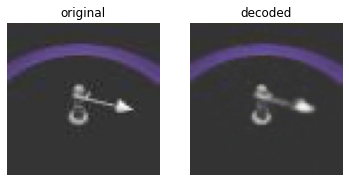

In [7]:
show_true_vs_decoded(encoding, model, idx=0)


In [8]:
G = get_graph(points,dist_type='euclidean',start_k=1, max_k=1000)
k = max(deg for deg in G.degree)[1]
print('minimal degree for graph to be connected is {}'.format(k))

minimal degree for graph to be connected is 4


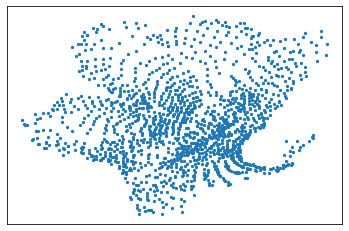

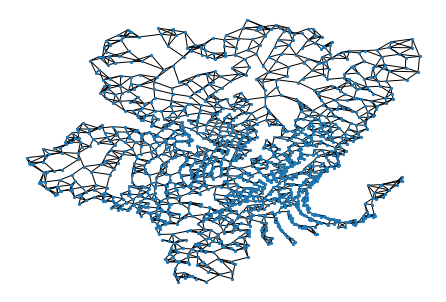

In [9]:
display_latent_space(G, with_edges=False)
display_latent_space(G, with_edges=True)

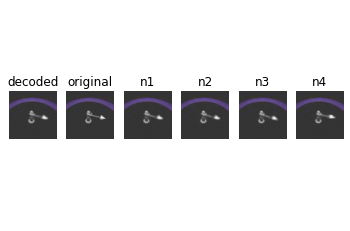

In [10]:
display_neighbors_for_latent_image(encoding,model, 0)

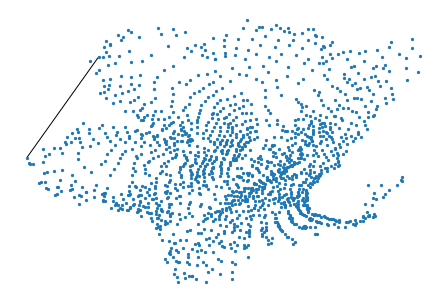

Average mean squared error of interpolation outputs to closest true images in dataset:
8.89


<Figure size 432x288 with 0 Axes>

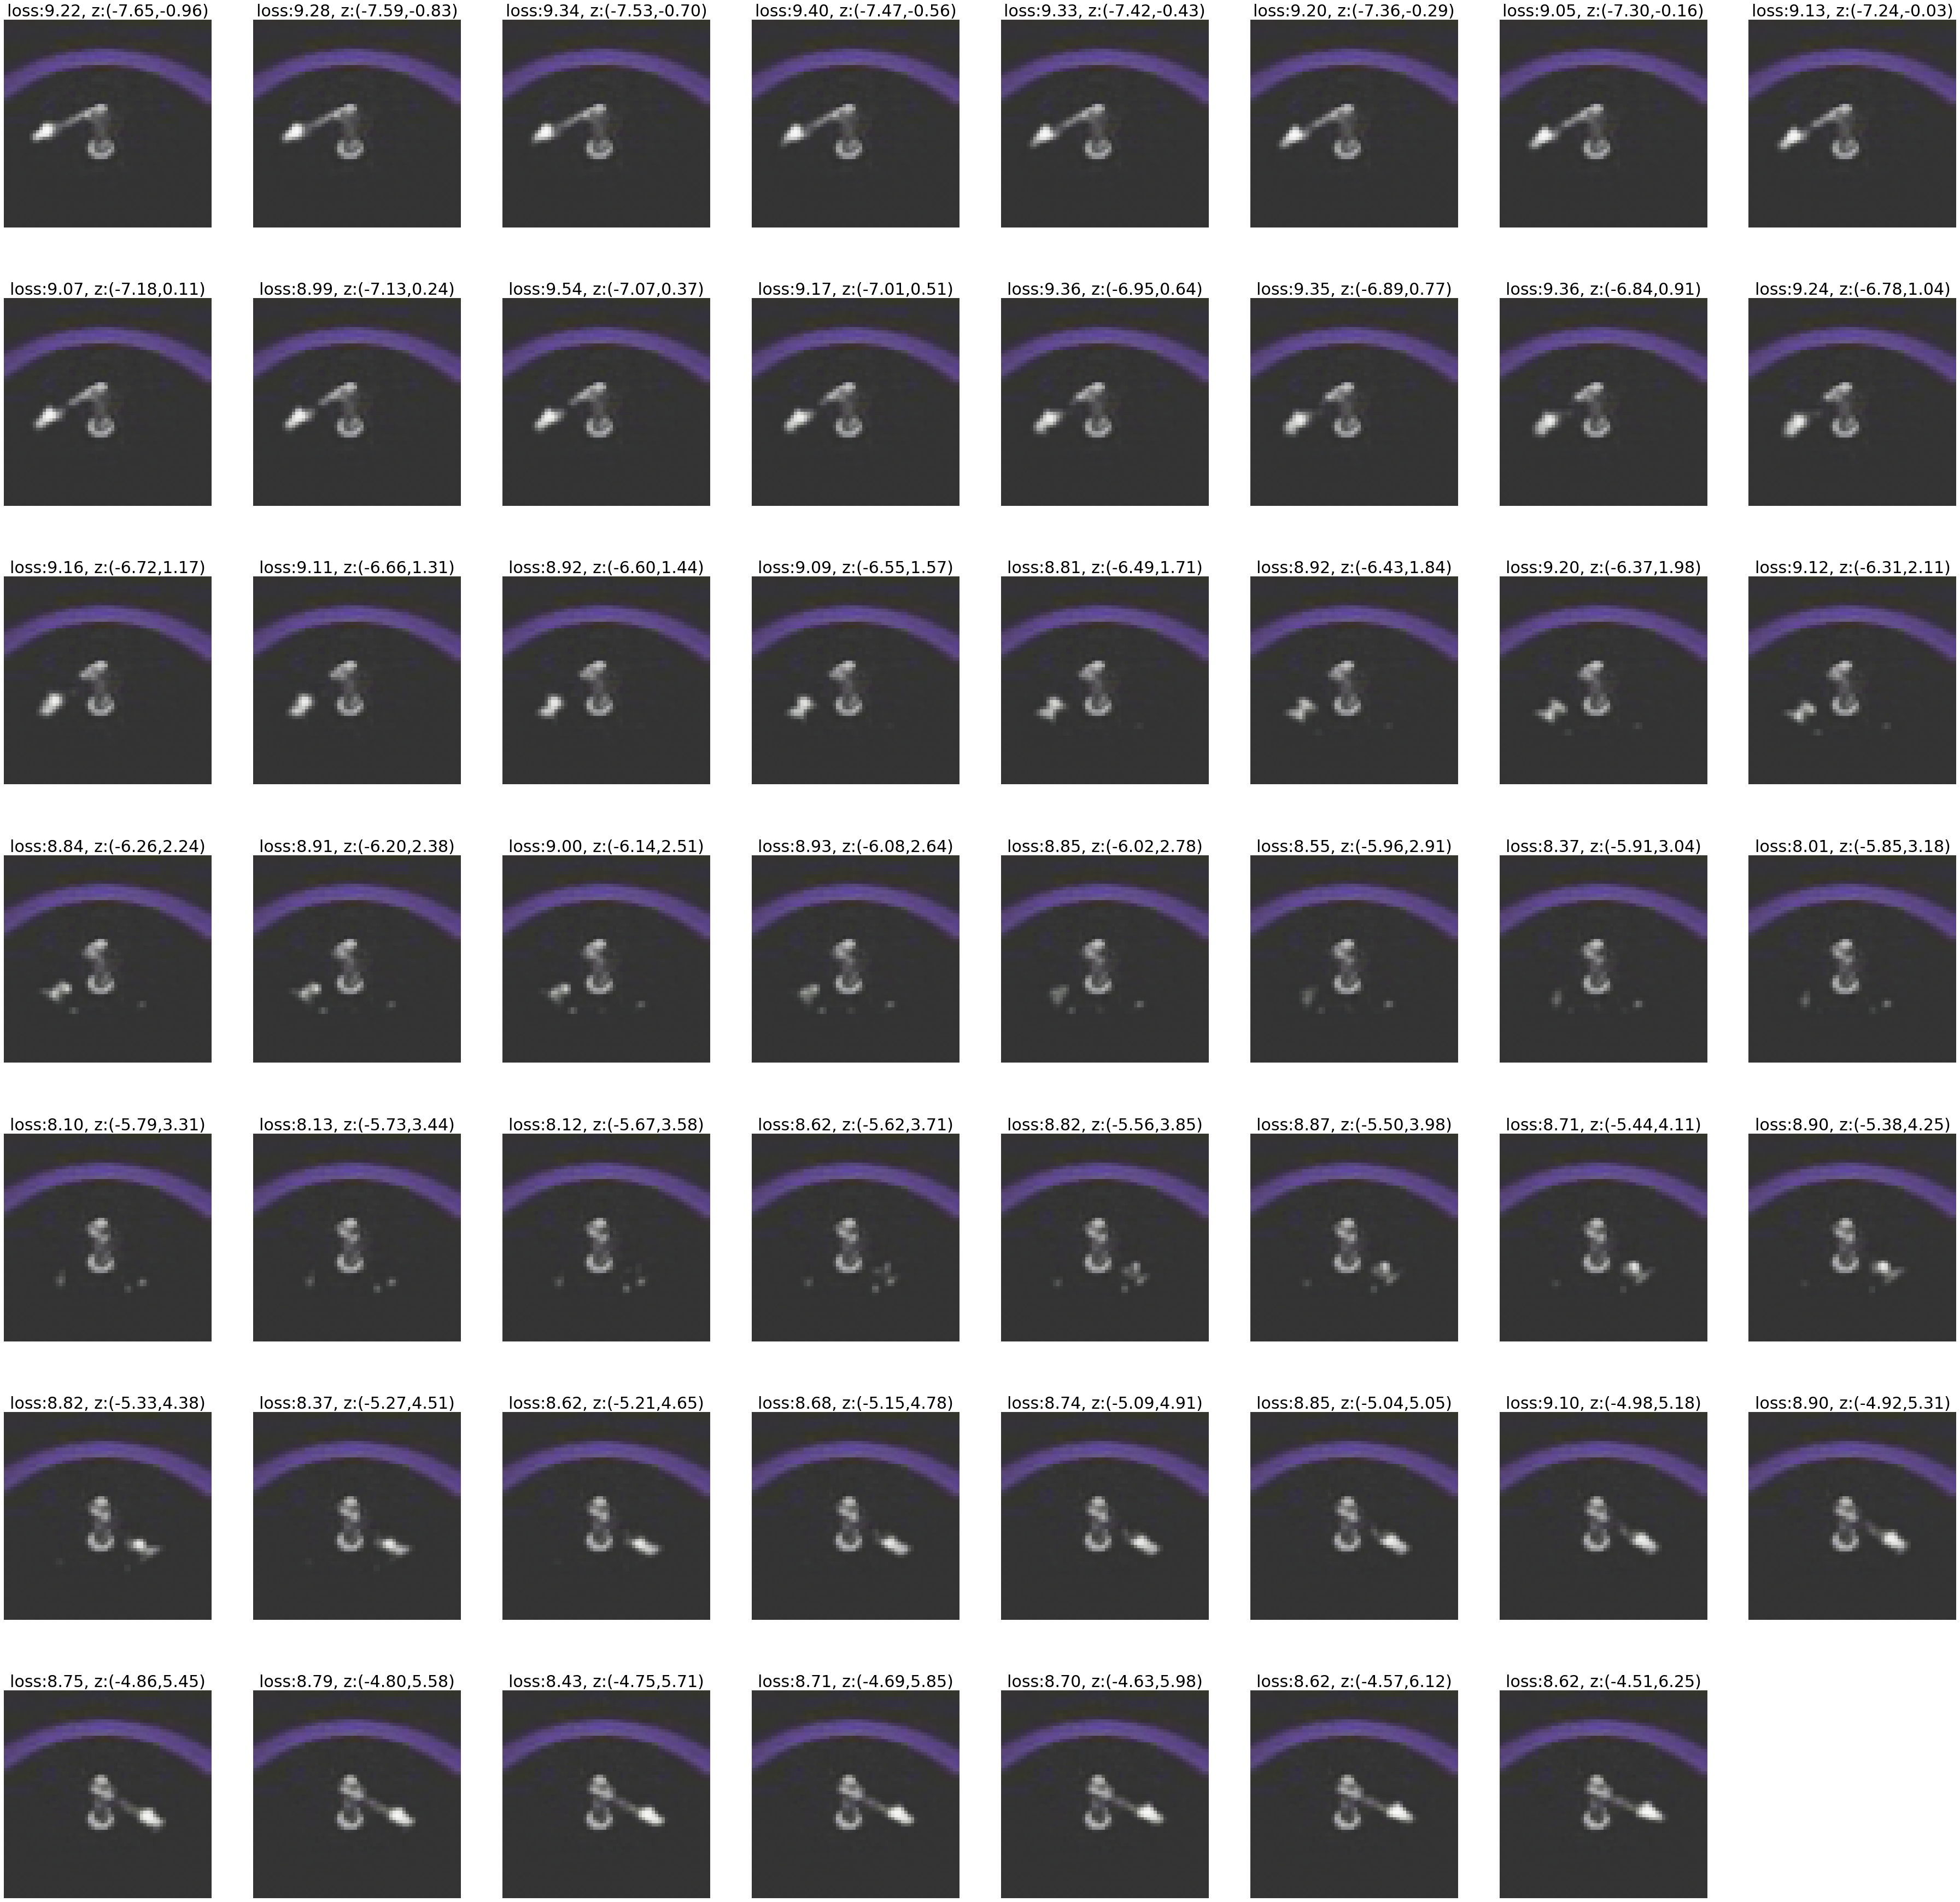

In [25]:
#demonstrating naive linear interpolation in latent space artifacts, with benchmarks/model2
bottom_node = 801
top_node = 968
path =[801, 968]
display_path_graph(G, path)

path = [bottom_node,top_node]

interpolation_path = surf(path, 55)
imgs = [(latent_to_img(z, model)*255).astype(np.uint8) for z in interpolation_path]
avg_loss, losses = average_interpolation_mse(encoding, imgs)


msg_fmt = "Average mean squared error of interpolation outputs to closest true images in dataset:\n{:.2f}"
print(msg_fmt.format(avg_loss))
show_interpolation(imgs, interpolation_path, losses)

most distant points are at indexes (801, 968)


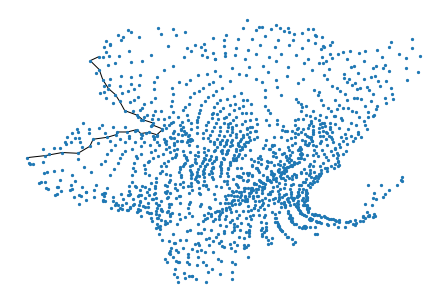

In [26]:
## shortest_path for two most distant points ##
source, dest = 801, 968#get_most_distant_points(points, dist_type='euclidean')
print("most distant points are at indexes {}".format((source, dest)))
G2, path = get_shortest_path_graph(G, source, dest)
display_latent_space(G2, with_edges=True)


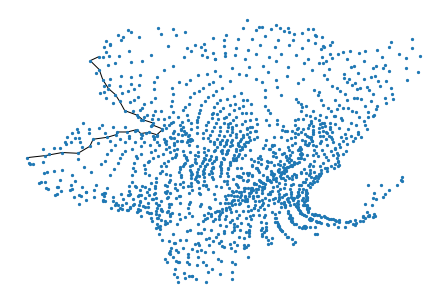

55


In [23]:
n_images=len(path)*2+1 #assuming number of images is k*len(path) + 1
interpolation_path = surf(path, 3) # one image between every two points...
display_path_graph(G, path)
print(len(interpolation_path))

Average mean squared error of interpolation outputs to closest true images in dataset:
8.32


<Figure size 432x288 with 0 Axes>

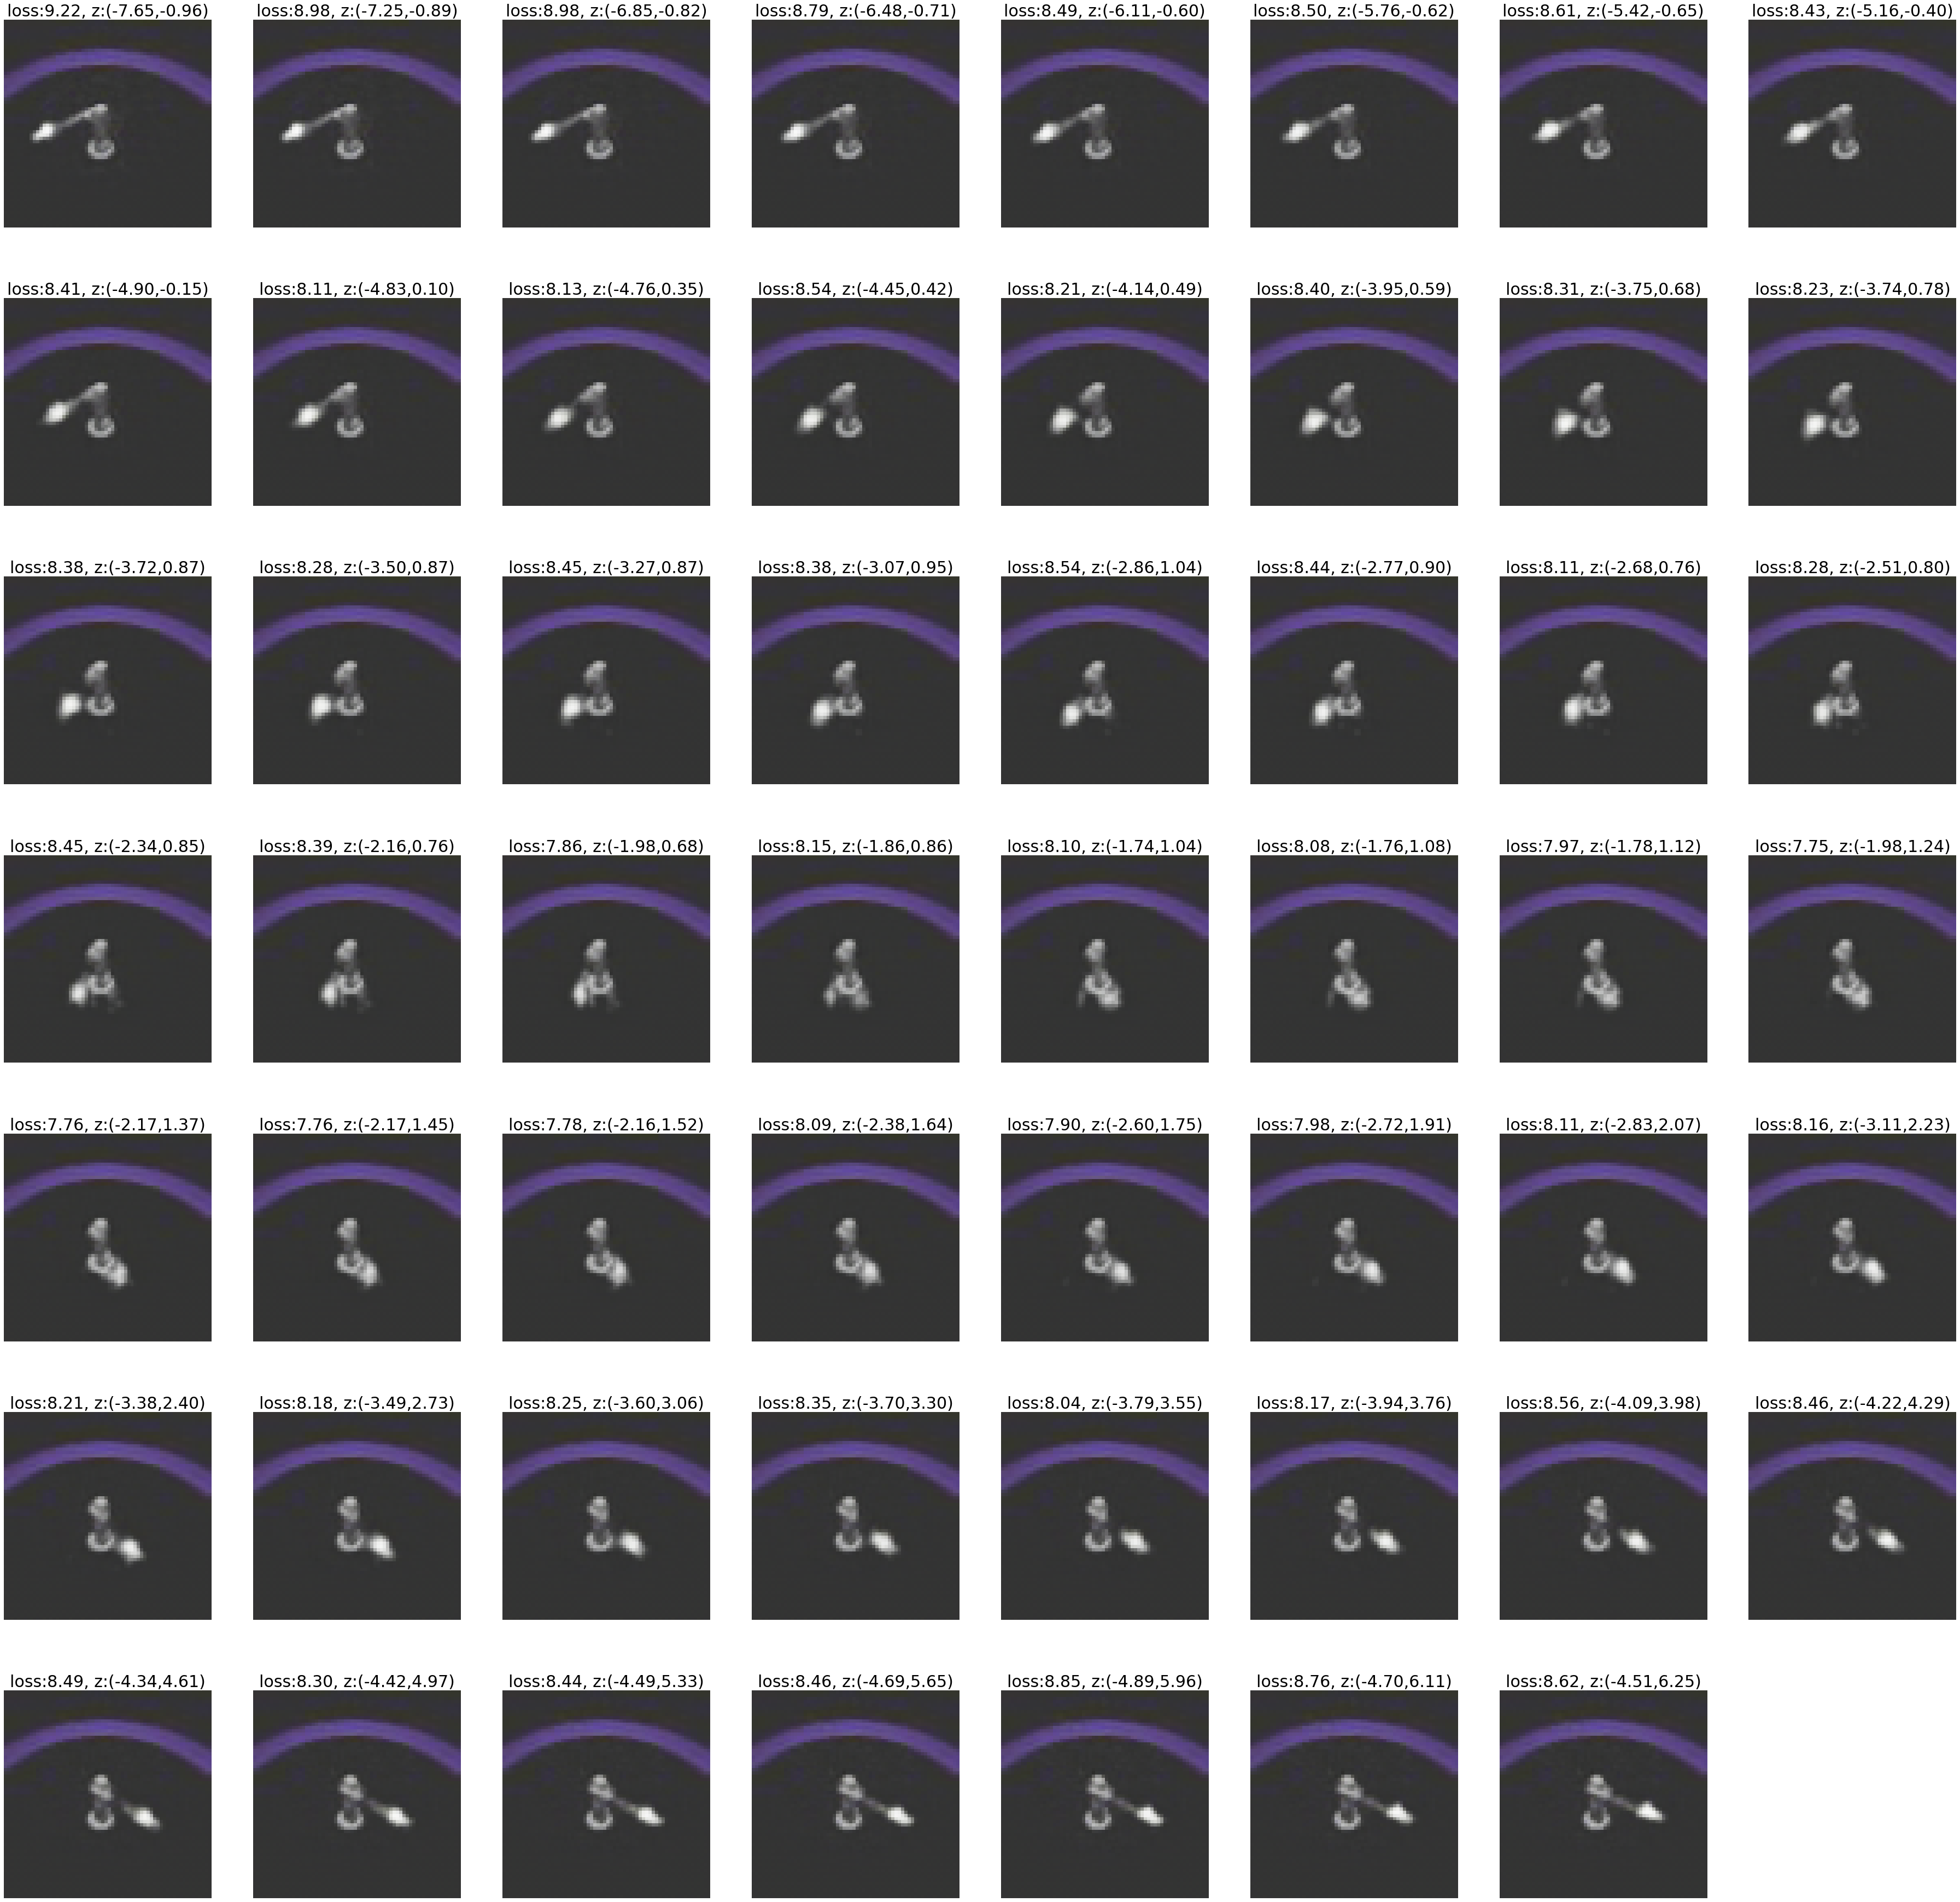

In [24]:
fig = plt.figure()

fig=plt.figure(figsize=(64, 64))
columns = 8
rows = np.ceil(len(interpolation_path)/columns)
loss= 0.0
for i in range(1, len(interpolation_path) +1):
    z=  interpolation_path[i-1]
    img = (latent_to_img(z, model)*255).astype(np.uint8)
    curr_loss=  interpolation_mse(encoding, img)
    loss+= curr_loss
    ax = fig.add_subplot(rows, columns, i)
    ax.axis('off')
    ax.set_title("loss:{:.2f}, z:({:.2f},{:.2f})".format(curr_loss, z[0], z[1]), fontsize=30)
    ax.imshow(img)

msg_fmt = "Average mean squared error of interpolation outputs to closest true images in dataset:\n{:.2f}"
print(msg_fmt.format(loss/len(interpolation_path)))
plt.show();

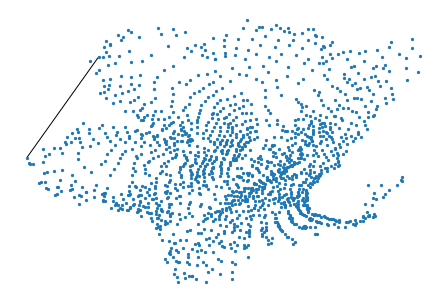

<Figure size 432x288 with 0 Axes>

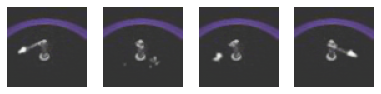

In [361]:
#demonstrating naive linear interpolation in latent space artifacts, with benchmarks/model2

nodes = list(G.nodes(data=True))
rightmost_nodes = sorted(nodes, key=lambda x:-x[1]['pos'][0])[-70:]
top_nodes = sorted(rightmost_nodes, key=lambda x:x[1]['pos'][1])

bottom_node = rightmost_nodes[-1][0]
top_node = top_nodes[-1][0]

G3= nx.Graph()
G3.add_nodes_from(G.nodes(data=True))

G3.add_edge(bottom_node, top_node)
nx.draw(G3, pos, node_size=5)
u = points[bottom_node]
v = points[top_node]
middle = generate_extra_points(u,v,4)

pos = nx.get_node_attributes(G3,'pos')
interpolation_path = [u]+ middle + [v]

fig = plt.figure()

w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 6
rows = np.ceil(len(interpolation_path)/columns)
for i in range(1, len(interpolation_path) +1):
    img = latent_to_img(interpolation_path[i-1])
    
    ax = fig.add_subplot(rows, columns, i)
    ax.axis('off')
    ax.imshow(img)
plt.show()


<Figure size 432x288 with 0 Axes>

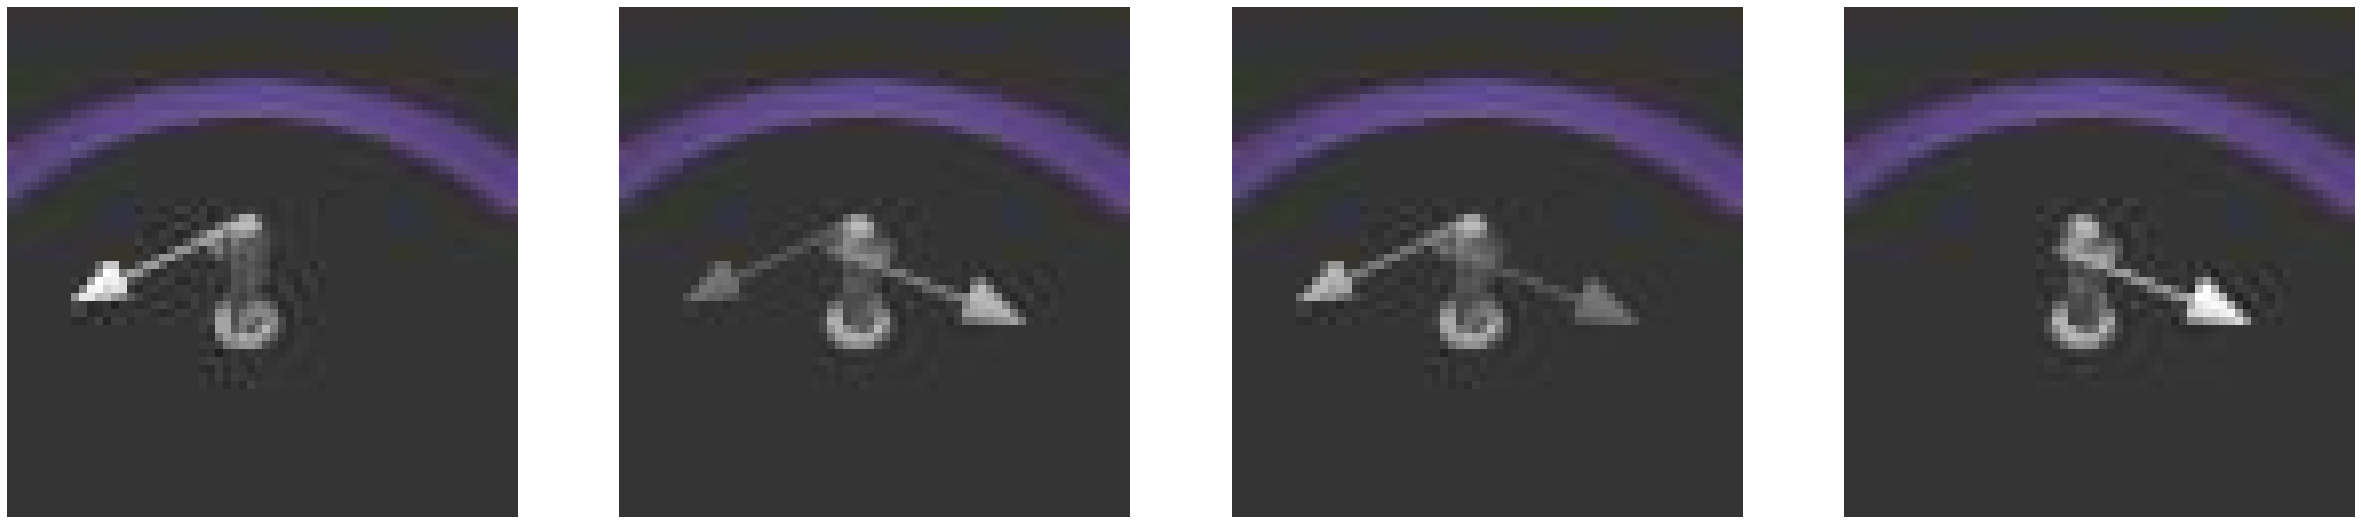

In [362]:
#demonstrating naive linear interpolation in pixel domain, with 2 degrees of freedom images

import PIL.Image as Image
u_path = points_data[bottom_node]['path']
v_path = points_data[top_node]['path']

u_img=np.asarray(Image.open(u_path))
v_img = np.asarray(Image.open(v_path))

images = generate_extra_points(u_img, v_img, 4)
interpolation = [u_img] + images + [v_img]

fig = plt.figure()

w=10
h=10
fig=plt.figure(figsize=(64,64))
columns = 6
for i in range(1, len(interpolation) +1):
    img = interpolation[i-1].astype(np.uint8)
    ax = fig.add_subplot(rows, columns, i)
    ax.axis('off')
    #ax.set_aspect('equal')


    ax.imshow(img)
#plt.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


# Part 2- DAE training

In [30]:
# Dataset class used for training

from torch.utils.data import Dataset
from torchvision import transforms
import os
import torch
import PIL.Image as Image


def add_noise_to_img(img, noise_param=0.2, noise_type='normal'):
    if noise_type == 'normal':
        noise = torch.randn(img.size()) * noise_param
        return img + noise.to(img.device)
    else:
        img = img.clone()
        noise = torch.rand(img.size())
        img[noise < noise_param] = 0
        return img

class ProjectDataset(Dataset):

    def __init__(self, root_dir,device, endswith = '.jpg', cache=True, noise=0.2, noise_type='normal'):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        img_list_temp = os.listdir(root_dir)
        self.root_dir = root_dir
        self.img_list = [img_path for img_path in img_list_temp if img_path.endswith(endswith)]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        self.device = device

        self.cache = cache
        self.images_cache = [None] * len(self.img_list)
        self.noise = noise
        self.noise_type = noise_type

    def get_img_paths(self):
        return self.img_list

    def get_img(self, idx):
        img_name = os.path.join(self.root_dir, self.img_list[idx])
        if self.cache and self.images_cache[idx] is not None:
            image = self.images_cache[idx]
        else:
            image = Image.open(img_name)
            image = self.transform(image)
            image = image.to(self.device)
            if self.cache:
                self.images_cache[idx] = image
        return image

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir, self.img_list[idx])
        image = self.get_img(idx)
        image_noise = add_noise_to_img(image, self.noise, self.noise_type)
        sample = {'noise_img': image_noise, 'img' : image, 'path': img_name}
        return sample


In [28]:
# model used for training
import torch
from torch import nn

class Encoder(nn.Module):
    def __init__(self, dims, out_channels):
        """dims: number of dimensions is latent space"""
        """size of first hidden convolution layer. assumed to be a multiple of 64"""
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(3, out_channels, 3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, stride=2)

        self.conv2 = nn.Conv2d(out_channels, out_channels//2, 3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, stride=1)

        self.conv3 = nn.Conv2d(out_channels//2, out_channels//4, 3, stride=2)
        self.relu3 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(144 * (out_channels//64), dims) # hack to figure out linear size...

    def forward(self, x):
        x = self.conv1(x)  # [b, 64, 32, 32]

        x = self.relu1(x)
        x = self.maxpool1(x)  # [b, 64, 16, 16]
        x = self.conv2(x)  # [b, 32, 8, 8]

        x = self.relu2(x)
        x = self.maxpool2(x)  # [b, 32, 7, 7]
        x = self.conv3(x)  # [b, 16, 3, 3]

        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)  # [b, 2, 1, 1]
        return x


class Decoder(nn.Module):
    def __init__(self, dims):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(dims, 4096)
        self.deconv1 = nn.ConvTranspose2d(16, 32, 3, stride=2)
        self.relu1 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(32, 64, 3, stride=2)
        self.relu2 = nn.ReLU()
        self.deconv3 = nn.ConvTranspose2d(64, 3, 2, stride=1, padding=2)
        self.tanh = nn.Tanh()

    def forward(self, x):
        n_samples = x.size(0)
        x = self.fc1(x)
        x = x.reshape(n_samples, -1, 16, 16)
        x = self.deconv1(x)  # b, 8, 3, 3
        x = self.relu1(x)
        x = self.deconv2(x)  # b, 16, 9, 9
        x = self.relu2(x)
        x = self.deconv3(x)  # b, 32, 16, 16
        x = self.tanh(x)
        return x


class AE(nn.Module):

    def __init__(self, dims, out_channels):
        super(AE, self).__init__()
        self.encoder = Encoder(dims, out_channels)
        self.decoder = Decoder(dims)

    def forward(self, x):
        x = self.encoder(x)
        vector = x.reshape(-1, x.shape[1])
        x = self.decoder(vector)
        return x, vector

    def load(self, path, dims, device, out_channels):
        dic = torch.load(path, map_location=torch.device(device))
        e = Encoder(dims, out_channels=out_channels)
        d = Decoder(dims)
        e.load_state_dict(dic['encoder'])
        d.load_state_dict(dic['decoder'])
        self.encoder = e
        self.decoder = d

    def save(self, path):
        dic = {'encoder': self.encoder.state_dict(), 'decoder': self.decoder.state_dict()}
        torch.save(dic, path)

    def loss(self, img, outputs, criterion):
        loss = criterion(outputs, img)
        return loss

    def perceptual_loss(self, img, outputs, criterion, loss_network, loss_network_weight):
        with torch.no_grad():
            xc = img.detach()
        features_y = loss_network(outputs)
        features_xc = loss_network(xc)
        with torch.no_grad():
            f_xc_c = features_xc[2].detach()
        loss_c = criterion(features_y[2], f_xc_c)
        loss = loss_network_weight * loss_c
        return loss

In [29]:
from torch import nn
from collections import namedtuple

LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])

# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }

    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [ ]:
### create grid ###
batch_sizes = [4, 8, 16]
weights = [(1, 0)]
out_channels = [64, 128, 256]
noises = [0.1, 0.2, 0.5]
noise_types = ['normal', 'white']

run_configurations = []
for batch_size in batch_sizes:
    for weight in weights:
        for out_channel in out_channels:
            for noise in noises:
                for noise_type in noise_types:
                    run_configurations.append(dict(
                        lr=1e-2,
                        wd=1e-5,
                        num_epochs=300,
                        batch_size=batch_size,
                        step_size=75,
                        dims=2,
                        criterion_weight=weight[0],
                        loss_network_weight=weight[1],
                        out_channels=out_channel,
                        noise=noise,
                        noise_types=noise_type,
                        IMAGES_PATH='images2d'
                    )
                    )
print('\n'.join([str(c) for c in run_configurations]))
print(len(run_configurations))


In [ ]:
import json
import os
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader

from dataset import ProjectDataset
from models.DAE import AE

from models.LossNN import LossNetwork
import torchvision.models.vgg as vgg

PATH_TO_SAVE = 'runs'
for j, run_configuration in enumerate(run_configurations, start=1):
    torch.manual_seed(42)

    lr, wd, num_epochs, batch_size, step_size, dims, criterion_weight, loss_network_weight, out_channels, noise, noise_type, IMAGES_PATH= tuple(run_configuration.values())
    device = get_device()
    model = AE(dims=dims, out_channels=out_channels).to(device)
    vgg_model = vgg.vgg16(pretrained=True)
    loss_network = LossNetwork(vgg_model).to(device)
    loss_network.eval()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1)

    idx_to_save = 0

    folder = '_'.join(['{}_{}'.format(k, v) for k, v in run_configuration.items()])
    save_run_as = osp.join(PATH_TO_SAVE, folder)
    if osp.exists(save_run_as):
        print('skipping configuration {} already exists\n'.format(save_run_as))
        continue
    if not osp.exists(save_run_as):
        os.makedirs(save_run_as, exist_ok=True)

    dataset = ProjectDataset(IMAGES_PATH, device, noise=noise, noise_type=noise_type)
    trainloader = DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=False)

    ##### Training

    loss_history = []

    print('***** Start training {}/{} configurations *****\n'.format(j, len(run_configurations)))
    for epoch in range(num_epochs):
        run_losses = []
        for i, data in tqdm(enumerate(trainloader)):
            optimizer.zero_grad()

            img = data['img']
            outputs, _ = model(data['noise_img'])
            if loss_network_weight>0:
                perceptual_loss = model.perceptual_loss(img, outputs, criterion, loss_network, loss_network_weight)
            else:
                perceptual_loss =0
            criterion_loss = model.loss(img, outputs, criterion)
            loss = criterion_weight * criterion_loss + loss_network_weight* perceptual_loss
            loss.backward()
            optimizer.step()
            run_losses.append(outputs.shape[0] * loss.item())
        if scheduler is not None:
            scheduler.step()
        epoch_loss = sum(run_losses) / len(dataset)
        loss_history.append(epoch_loss)
        print('\n epoch [{}/{}], loss:{:.6f} #config={}'.format(epoch + 1, num_epochs, epoch_loss, j))

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            img_temp = to_img(outputs)
            img_to_save = np.asarray(img_temp[idx_to_save].permute(1, 2, 0).detach().cpu())
            to_save_path = osp.join(save_run_as, 'epoch{}.jpg'.format(epoch))
            plt.imsave(to_save_path, np.uint8(img_to_save * 255))

            loss_path = osp.join(save_run_as, 'losses.txt')
            if epoch == 0 and osp.exists(loss_path):
                os.remove(loss_path)

            with open(loss_path, 'a+') as f:
                f.write('{}\n'.format(loss_history[-1]))
    print('***** Done training {}/{} configurations *****\n'.format(j, len(run_configurations)))

    model.save(os.path.join(save_run_as, 'model.pth'))
    with open(os.path.join(save_run_as, 'config.json'), 'w') as f:
        json.dump(run_configuration, f)

In [ ]:

def encode(model_path):
    device = get_device()
    path_to_model = Path(model_path) / Path('model.pth')
    graph_dump_path = Path(model_path)/ Path('encoding.json')
    config_path = Path(model_path) / Path('config.json')
    with config_path.open() as f:
        config = json.load(f)
    images_path = config['IMAGES_PATH']
    out_channels = config['out_channels']
    dims = config['dims']

    state_dict = torch.load(path_to_model, map_location=torch.device(device))
    encoder = Encoder(dims, out_channels)
    encoder.load_state_dict(state_dict['encoder'])
    encoder.to(device)
    dataset = ProjectDataset(images_path, device=device)
    data_loader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)

    points = []
    for i, datum in enumerate(data_loader):
        image_path = datum['path'][0]
        image = datum['img']
        vector = encoder(image)
        z = vector.flatten()
        points.append({'z': z.tolist(), 'path': image_path})
    with graph_dump_path.open('w') as f:
        json.dump(points, f)
        
encode(save_run_as)        
